In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-lightning
!pip install lightning-bolts
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 5.7 MB/s 
     |████████████████████████████████| 512 kB 71.9 MB/s 
     |████████████████████████████████| 125 kB 78.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 329 kB 7.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install git+https://github.com/PytorchLightning/lightning-bolts.git@master --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PytorchLightning/lightning-bolts.git (to revision master) to /tmp/pip-req-build-8mh1p9xg
  Running command git clone -q https://github.com/PytorchLightning/lightning-bolts.git /tmp/pip-req-build-8mh1p9xg
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for lightning-bolts: filename=lightning_bolts-0.7.0.dev0-py3-none-any.whl size=336352 sha256=1ac526597d4a49364ba114ab884a3aa2d246b52aa5c733905fec7d689bc92122
  Stored in directory: /tmp/pip-ephem-wheel-cache-emqynzc2/wheels/0c/33/1a/c15aadb414d9fe5c7e0ca4f472168aa03a652c17b30d31c523
Successfully built lightning-bolts
  Attempting uninstall: lightning-bolts
    Found existing installation: lightning-bolts 0.6.0.post1
    Uninstalling lightning-bolts-0.6.0.post1:
      Successfully uninstalled lightning-bolts-0.6.0.post1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
import pl_bolts
import torchvision
import torchmetrics
import pytorch_lightning as pl

from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy

from torchvision import models, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

/usr/local/lib/python3.8/dist-packages/pl_bolts/callbacks/data_monitor.py:20: UnderReviewWarning: The feature warn_missing_pkg is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  warn_missing_pkg("wandb")
/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised

In [ ]:
data_dir = '/content/drive/MyDrive/ABIDE Dataset/ABIDE I'
os.listdir(data_dir)

['Autistic', 'Non_Autistic']

In [ ]:
basic_transformer = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(
         mean = [0.485, 0.485, 0.406], std = [0.229, 0.224, 0.225]
     )
    ]
)

asd_dataset = ImageFolder(data_dir, transform = basic_transformer)
len(asd_dataset)

39376

In [ ]:
asd_dataset.classes

['Autistic', 'Non_Autistic']

In [ ]:
def show_img_example(img, label):
  print('Label: ', asd_dataset.classes[label], "(" + str(label) + ")")
  plt.imshow(img.permute(1, 2, 0))

Label:  Autistic (0)


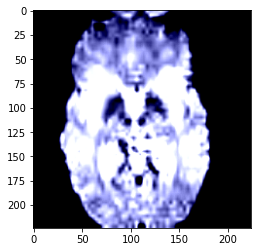

In [ ]:
show_img_example(*asd_dataset[5])

Label:  Non_Autistic (1)


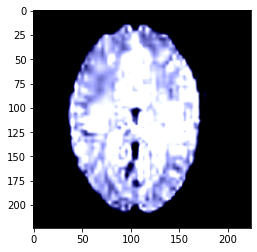

In [ ]:
show_img_example(*asd_dataset[25422])

In [ ]:
class AutismDataModule(pl.LightningDataModule):
   def __init__(self, data_dir = '/content/drive/MyDrive/ABIDE Dataset/ABIDE I' ):
       super().__init__()

       self.data_dir = data_dir
       self.transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.1),
            transforms.RandomRotation(10),
               transforms.ToTensor(),
               transforms.Normalize(
                   mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)
               ),

        ]
      )

   def setup(self, stage=None):
      asd_full = ImageFolder(self.data_dir, transform = self.transform)
      length = len(asd_full)
      val_split_size = 0.25
      train_length = round(length * (1- val_split_size))
      val_length = length - train_length

      self.asd_train, self.asd_val = \
        random_split(asd_full, [train_length, val_length])

   def train_dataloader(self):
       train_dataloader = \
       DataLoader(self.asd_train, batch_size = 32, shuffle = True)

       return train_dataloader

   def val_dataloader(self):
       val_dataloader = \
       DataLoader(self.asd_val, batch_size = 32)

       return val_dataloader




In [ ]:
asd_dm = AutismDataModule()
asd_dm.setup()

In [ ]:
train_dl = asd_dm.train_dataloader()
len(train_dl)

923

In [ ]:
valid_dl = asd_dm.val_dataloader()
len(valid_dl)

308

In [ ]:
for inp, label in train_dl:
  print('{} : {}'.format(inp, label))
  print('Input shape: ', inp.shape)
  print('Labels shape: ', label.shape)
  break

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

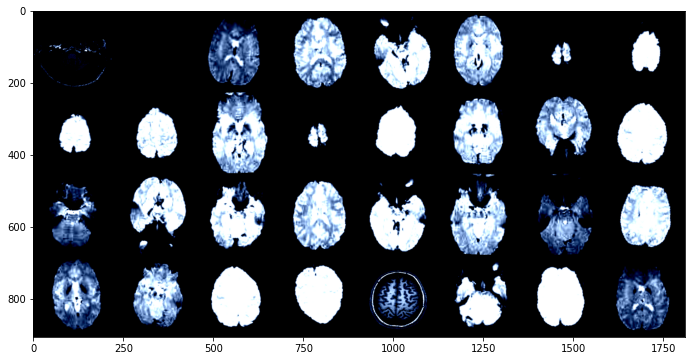

In [ ]:
def show_batch_images(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
    break

show_batch_images(train_dl)

#RESNET-18 MODEL (TRANSFER LEARNING)

In [ ]:
from torch.nn.modules import loss
class AutismClassifier(pl.LightningModule):
  def __init__(self, num_classes = 2, lr = 1e-3):
      super().__init__()
      self.save_hyperparameters()

      self.backbone = models.resnet18(pretrained = True)

      self.finetune_layer = torch.nn.Linear(self.backbone.fc.out_features, num_classes)

  def training_step(self, batch, batch_idx):

      x, y = batch
      

      with torch.no_grad():
           features = self.backbone(x)

      preds = self.finetune_layer(features)
      

      loss = cross_entropy(preds, y)
     

      metrics = {'train_loss': loss}
      self.log_dict(metrics, on_step= False, on_epoch= True,
                    prog_bar = True, logger = True)
      
      return loss


  def validation_step(self, batch, bach_idx):

      x, y = batch
      

      features = self.backbone(x)
      preds = self.finetune_layer(features)
      
      loss = cross_entropy(preds, y)
      

      metrics = {'valid_loss': loss}
      self.log_dict(metrics, on_step = False, on_epoch= True,
                    prog_bar = True, logger = True)
      
      return metrics


  def configure_optimizers(self):

    optimizer = Adam(self.parameters(), lr = self.hparams.lr)
 
    return optimizer

In [ ]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'resnet18_bb_frozen')

In [ ]:
from pytorch_lightning.trainer import trainer
classifier = AutismClassifier()

trainer = pl.Trainer(max_epochs = 20, 
                     limit_train_batches=20, 
                     log_every_n_steps= 10, 
                     logger = logger, gpus = 1)

trainer.fit(classifier, asd_dm)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type   | Params
------------------------------------------
0 | backbone       | ResNet | 11.7 M
1 | finetune_layer | Linear | 2.0 K 
------------------------------------------
11.7 M    Trainable params
0         Non-trainable 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

metrics.head()

,valid_loss,epoch,step,train_loss
0,0.572692,0,19,NaN
1,NaN,0,19,0.455990
2,0.364016,1,39,NaN
3,NaN,1,39,0.268968
4,0.670374,2,59,NaN


In [ ]:
train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

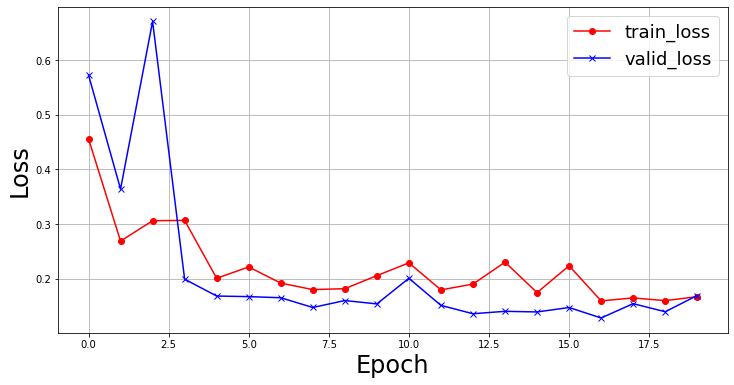

In [ ]:
fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train_loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid_loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_resnet18.png')

In [ ]:
from torch.nn.modules import loss
class AutismClassifier(pl.LightningModule):
  def __init__(self, num_classes = 2, lr = 1e-3):
      super().__init__()
      self.save_hyperparameters()

      self.backbone = models.resnet18(pretrained = True)

      self.finetune_layer = torch.nn.Linear(self.backbone.fc.out_features, num_classes)

  def training_step(self, batch, batch_idx):

      x, y = batch
      

      if self.trainer.current_epoch < 10:
            with torch.no_grad():
                features = self.backbone(x)
      else:
             features = self.backbone(x)
        
      preds = self.finetune_layer(features)

      loss = cross_entropy(preds, y)
     

      metrics = {'train_loss': loss}
      self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
      return loss
    


  def validation_step(self, batch, bach_idx):

      x, y = batch
      

      features = self.backbone(x)
      preds = self.finetune_layer(features)
      
      loss = cross_entropy(preds, y)
      

      metrics = {'valid_loss': loss}
      self.log_dict(metrics, on_step = False, on_epoch= True,
                    prog_bar = True, logger = True)
      
      return metrics


  def configure_optimizers(self):

    optimizer = Adam(self.parameters(), lr = self.hparams.lr)
 
    return optimizer

In [ ]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'resnet18_bb_unfrozen')

In [ ]:
classifier = AutismClassifier()

trainer = pl.Trainer(limit_train_batches = 20, max_epochs = 20, log_every_n_steps = 10,
                     logger = logger, gpus = 1)

trainer.fit(classifier, asd_dm)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

metrics.head()

,valid_loss,epoch,step,train_loss
0,0.446115,0,19,NaN
1,NaN,0,19,0.607506
2,0.413654,1,39,NaN
3,NaN,1,39,0.394976
4,0.437553,2,59,NaN


In [ ]:
train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

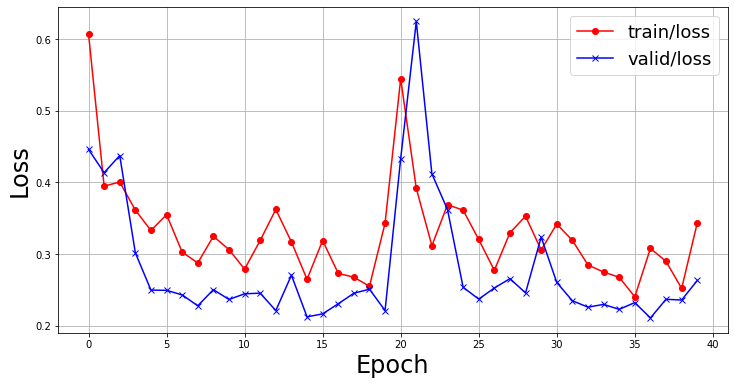

In [ ]:
fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_resnet18_unfrozen.png')

#VGG16 MODEL (TRANSFER LEARNING)

In [ ]:
from torch.nn.modules import loss
class AutismClassifier(pl.LightningModule):
  def __init__(self, num_classes = 2, lr = 1e-3):
      super().__init__()
      self.save_hyperparameters()

      self.backbone = models.vgg16_bn(pretrained = True)

      self.finetune_layer = torch.nn.Linear(self.backbone.classifier[6].out_features, num_classes)

  def training_step(self, batch, batch_idx):

      x, y = batch
      

      with torch.no_grad():
           features = self.backbone(x)

      preds = self.finetune_layer(features)
      

      loss = cross_entropy(preds, y)
      # accuracy_score = torchmetrics.functional.accuracy(preds, y)

      metrics = {'train_loss': loss}
      self.log_dict(metrics, on_step= False, on_epoch= True,
                    prog_bar = True, logger = True)
      
      return loss


  def validation_step(self, batch, bach_idx):

      x, y = batch
      

      features = self.backbone(x)
      preds = self.finetune_layer(features)
      
      loss = cross_entropy(preds, y)
      # accuracy_score = torchmetrics.functional.accuracy(preds, y, 'binary')

      metrics = {'valid_loss': loss}
      self.log_dict(metrics, on_step = False, on_epoch= True,
                    prog_bar = True, logger = True)
      
      return metrics


  def configure_optimizers(self):

    optimizer = Adam(self.parameters(), lr = self.hparams.lr)
 
    return optimizer

In [ ]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'vgg16_bb_unfrozen')

In [ ]:
classifier = AutismClassifier()

trainer = pl.Trainer(limit_train_batches = 20, max_epochs = 20, log_every_n_steps = 10,
                     logger = logger, gpus = 1)

trainer.fit(classifier, asd_dm)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type   | Params
------------------------------------------
0 | backbone       | VGG    | 138 M 
1 | finetune_layer | Linear | 2.0 K 
------------------------------------------
138 M     Trainable params
0         Non-trainable 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

metrics.head()

,valid_loss,epoch,step,train_loss
0,0.446115,0,19,NaN
1,NaN,0,19,0.607506
2,0.413654,1,39,NaN
3,NaN,1,39,0.394976
4,0.437553,2,59,NaN


In [ ]:
train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

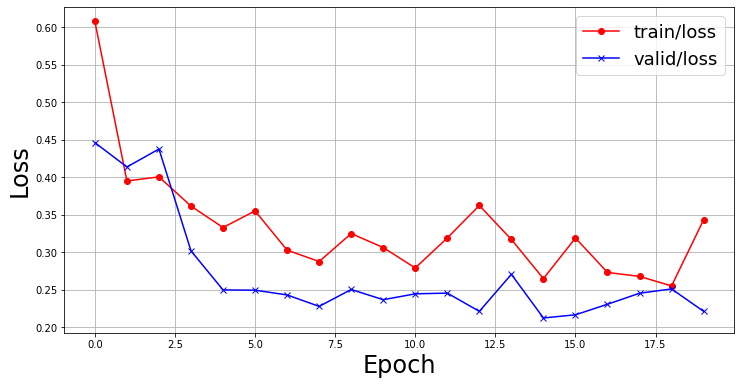

In [ ]:
fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_VGG16.png')

In [ ]:
from torch.nn.modules import loss
class AutismClassifier(pl.LightningModule):
  def __init__(self, num_classes = 2, lr = 1e-3):
      super().__init__()
      self.save_hyperparameters()

      self.backbone = models.vgg16_bn(pretrained = True)

      self.finetune_layer = torch.nn.Linear(self.backbone.classifier[6].out_features, num_classes)

  def training_step(self, batch, batch_idx):

      x, y = batch
      

      if self.trainer.current_epoch < 10:
            with torch.no_grad():
                features = self.backbone(x)
      else:
             features = self.backbone(x)
        
      preds = self.finetune_layer(features)

      loss = cross_entropy(preds, y)
     

      metrics = {'train_loss': loss}
      self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
      return loss


  def validation_step(self, batch, bach_idx):

      x, y = batch
      

      features = self.backbone(x)
      preds = self.finetune_layer(features)
      
      loss = cross_entropy(preds, y)
      # accuracy_score = torchmetrics.functional.accuracy(preds, y, 'binary')

      metrics = {'valid_loss': loss}
      self.log_dict(metrics, on_step = False, on_epoch= True,
                    prog_bar = True, logger = True)
      
      return metrics


  def configure_optimizers(self):

    optimizer = Adam(self.parameters(), lr = self.hparams.lr)
 
    return optimizer

In [ ]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'vgg16_bb_no_frozen')

In [ ]:
classifier = AutismClassifier()

trainer = pl.Trainer(limit_train_batches = 20, max_epochs = 20, log_every_n_steps = 10,
                     logger = logger, gpus = 1)

trainer.fit(classifier, asd_dm)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

metrics.head()

,valid_loss,epoch,step,train_loss
0,0.405205,0,19,NaN
1,NaN,0,19,0.556661
2,0.617159,1,39,NaN
3,NaN,1,39,0.389973
4,0.428370,2,59,NaN


In [ ]:
train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

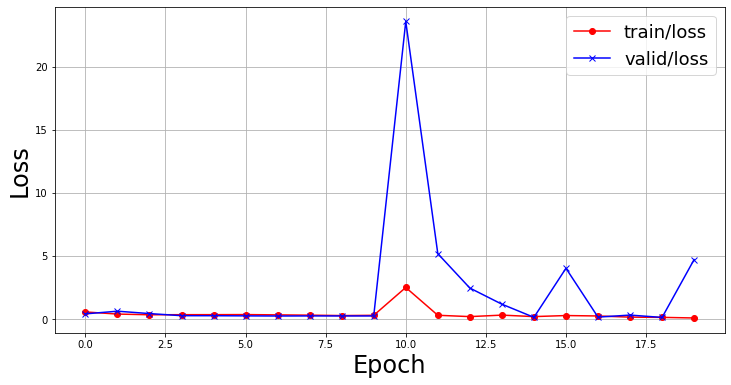

In [ ]:
fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_VGG16_unfrozen.png')

#AlexNet Model (Transfer Learning)

In [ ]:
from torch.nn.modules import loss
class AutismClassifier(pl.LightningModule):
  def __init__(self, num_classes = 2, lr = 1e-3):
      super().__init__()
      self.save_hyperparameters()

      self.backbone = models.alexnet(pretrained = True)

      self.finetune_layer = torch.nn.Linear(self.backbone.classifier[6].out_features, num_classes)

  def training_step(self, batch, batch_idx):

      x, y = batch
      

      if self.trainer.current_epoch < 10:
            with torch.no_grad():
                features = self.backbone(x)
      else:
             features = self.backbone(x)
        
      preds = self.finetune_layer(features)

      loss = cross_entropy(preds, y)
     

      metrics = {'train_loss': loss}
      self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
      return loss


  def validation_step(self, batch, bach_idx):

      x, y = batch
      

      features = self.backbone(x)
      preds = self.finetune_layer(features)
      
      loss = cross_entropy(preds, y)
      # accuracy_score = torchmetrics.functional.accuracy(preds, y, 'binary')

      metrics = {'valid_loss': loss}
      self.log_dict(metrics, on_step = False, on_epoch= True,
                    prog_bar = True, logger = True)
      
      return metrics


  def configure_optimizers(self):

    optimizer = Adam(self.parameters(), lr = self.hparams.lr)
 
    return optimizer

In [ ]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'Alexnet_bb_no_frozen')

In [ ]:
classifier = AutismClassifier()

trainer = pl.Trainer(limit_train_batches = 20, max_epochs = 20, log_every_n_steps = 10,
                     logger = logger, gpus = 1)

trainer.fit(classifier, asd_dm)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
IN

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

metrics.head()

,valid_loss,epoch,step,train_loss
0,0.335543,0,19,NaN
1,NaN,0,19,0.651948
2,0.216724,1,39,NaN
3,NaN,1,39,0.305761
4,0.192896,2,59,NaN


In [ ]:
train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

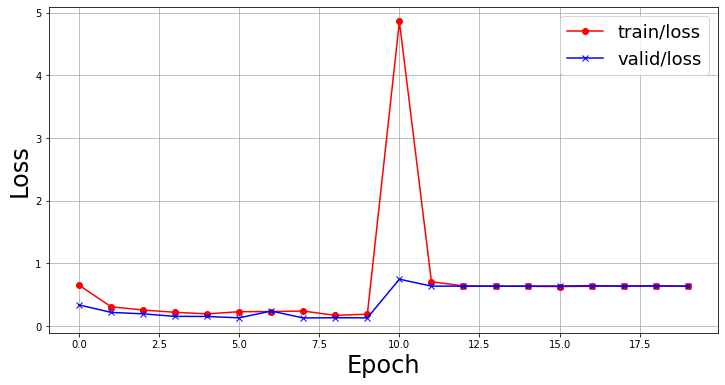

In [ ]:
fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_Alexnet_unfrozen.png')

In [ ]:
from torch.nn.modules import loss
class AutismClassifier(pl.LightningModule):
  def __init__(self, num_classes = 2, lr = 1e-3):
      super().__init__()
      self.save_hyperparameters()

      self.backbone = models.alexnet(pretrained = True)

      self.finetune_layer = torch.nn.Linear(self.backbone.classifier[6].out_features, num_classes)

  def training_step(self, batch, batch_idx):

      x, y = batch
      

      if self.trainer.current_epoch < 10:
            with torch.no_grad():
                features = self.backbone(x)
      else:
             features = self.backbone(x)
        
      preds = self.finetune_layer(features)

      loss = cross_entropy(preds, y)
     

      metrics = {'train_loss': loss}
      self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
      return loss


  def validation_step(self, batch, bach_idx):

      x, y = batch
      

      features = self.backbone(x)
      preds = self.finetune_layer(features)
      
      loss = cross_entropy(preds, y)
      # accuracy_score = torchmetrics.functional.accuracy(preds, y, 'binary')

      metrics = {'valid_loss': loss}
      self.log_dict(metrics, on_step = False, on_epoch= True,
                    prog_bar = True, logger = True)
      
      return metrics


  def configure_optimizers(self):

    optimizer = Adam(self.parameters(), lr = self.hparams.lr)
 
    return optimizer

In [ ]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'Alexnet_bb_no_frozen')

# Self Supervised Learning

##Contrastive Learning : SimCLR

In [ ]:
from pl_bolts.models.self_supervised import SimCLR

class AutismClassifier(pl.LightningModule):
    def __init__(self, num_classes = 2, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'

        simclr = SimCLR.load_from_checkpoint(weight_path, strict = False)

        self.backbone = simclr
        self.finetune_layer = torch.nn.Linear(2048, num_classes)
        
    def training_step(self, batch, batch_idx):
        x, y = batch

        if self.trainer.current_epoch < 10:
            with torch.no_grad():
                features = self.backbone(x)
        else:
            features = self.backbone(x)

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
       

        metrics = {'train_loss': loss}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return loss

    def validation_step(self, batch, batch_idx):
       
        x, y = batch   

        features = self.backbone(x)

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        

        metrics = {'valid_loss': loss}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return metrics

    def configure_optimizers(self):
        
        optimizer = Adam(self.parameters(), lr = self.hparams.lr)
        
        return optimizer

In [ ]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'simclr_bb_unfrozen')

In [ ]:
classifier = AutismClassifier()

trainer = pl.Trainer(max_epochs = 20,
                     limit_train_batches = 20, 
                     log_every_n_steps = 10, logger = logger, gpus = 1)

trainer.fit(classifier, asd_dm)

Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt" to /root/.cache/torch/hub/checkpoints/simclr_imagenet.ckpt


  0%|          | 0.00/229M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/saving.py:225: UnderReviewWarning: The feature SimCLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  obj = cls(**_cls_kwargs)
/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/simclr/simclr_module.py:138: UnderReviewWarning: The feature resnet50 is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return backbone(first_conv=self.first_conv, maxpool1=self.maxpool1, return_all_feature_maps=False)
/usr/local/lib/python3.8/dist-packages/pl_bolts/m

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

metrics.head()

,valid_loss,epoch,step,train_loss
0,0.601114,0,19,NaN
1,NaN,0,19,0.632676
2,0.558174,1,39,NaN
3,NaN,1,39,0.565983
4,0.512903,2,59,NaN


In [ ]:
train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

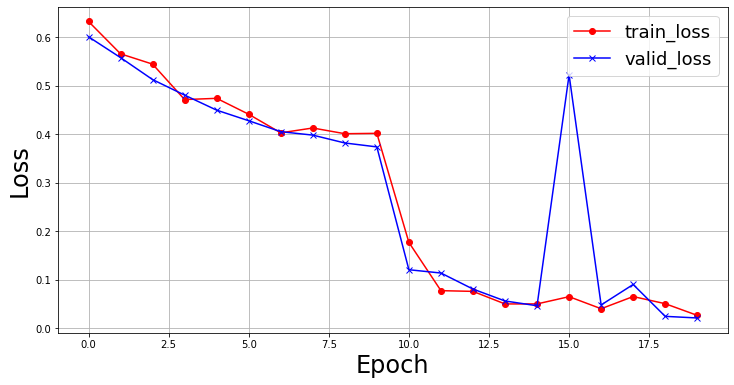

In [ ]:
fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train_loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid_loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_SimCLR.png')

#Non Contrastive Learning: SwAV

In [ ]:
from pl_bolts.models.self_supervised import SwAV

class AutismClassifier(pl.LightningModule):
    def __init__(self, num_classes = 2, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar'
        swav = SwAV.load_from_checkpoint(weight_path, strict = True)

        self.backbone = swav.model
        self.finetune_layer = torch.nn.Linear(3000, num_classes)
        
    def training_step(self, batch, batch_idx):
        x, y = batch

        if self.trainer.current_epoch < 10:
            with torch.no_grad():
                  features = self.backbone(x)[-1]
        else:
            features = self.backbone(x)[-1]

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
       

        metrics = {'train_loss': loss}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch   

        features = self.backbone(x)[-1]
        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        

        metrics = {'valid_loss': loss}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return metrics

    def configure_optimizers(self):
        
        optimizer = Adam(self.parameters(), lr = self.hparams.lr)

        return optimizer

In [ ]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'swav_bb_unfrozen')

In [ ]:
classifier = AutismClassifier()

trainer = pl.Trainer(max_epochs = 20,
                     limit_train_batches = 20, 
                     log_every_n_steps = 10, logger = logger, gpus = 1)

trainer.fit(classifier, asd_dm)  

Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar" to /root/.cache/torch/hub/checkpoints/swav_imagenet.pth.tar


  0%|          | 0.00/322M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type   | Params
------------------------------------------
0 | backbone       | ResNet | 28.4 M
1 | finetune_layer | Linear | 6.0 K 
------------------------------------------
28.4 M    Trainable params
0         Non-trainable 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

metrics.head()

,valid_loss,epoch,step,train_loss
0,0.649841,0,19,NaN
1,NaN,0,19,0.625706
2,0.624789,1,39,NaN
3,NaN,1,39,0.601904
4,0.610469,2,59,NaN


In [ ]:
train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

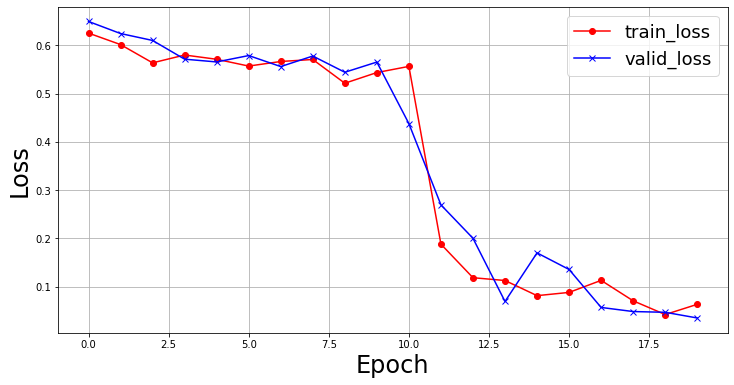

In [ ]:
fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train_loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid_loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_SwAV.png')